In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Membaca data dari file Excel
data = pd.read_excel("Data Curah Hujan Harian 2022-2024 Cleaned.xlsx", header=0)

# Menetapkan nama kolom secara manual jika kolom 'Tanggal' tidak ditemukan
data.columns = ['ID WMO', 'Curah Hujan', 'Kolom_Tidak_Terpakai', 'Keterangan']

# Menghapus kolom yang tidak relevan
data = data.drop(columns=['Kolom_Tidak_Terpakai', 'Keterangan'])


In [3]:
# Mengonversi 'Curah Hujan' menjadi numerik
data['Curah Hujan'] = pd.to_numeric(data['Curah Hujan'], errors='coerce')

# Mengonversi 'ID WMO' menjadi kolom Tanggal
data['Tanggal'] = pd.to_datetime(data['ID WMO'], errors='coerce')

# Menghapus baris yang mengandung tanggal kosong setelah konversi
data.dropna(subset=['Tanggal'], inplace=True)

C:\Users\muham\AppData\Local\Temp\ipykernel_9788\3940879352.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Tanggal'] = pd.to_datetime(data['ID WMO'], errors='coerce')


In [4]:
# Membuat fitur RR-1, RR-2, RR-3, RR-4 (curah hujan sebelumnya dalam 1-4 hari)
for i in range(1, 5):  # Membuat Lag 1 sampai Lag 4
    data[f'RR-{i}'] = data['Curah Hujan'].shift(i)

# Menghapus baris yang memiliki nilai kosong setelah pembuatan fitur
data.dropna(inplace=True)

# Menentukan fitur (RR-1, RR-2, ..., RR-4) dan target ('Curah Hujan')
X = data[['RR-1', 'RR-2', 'RR-3', 'RR-4']].values  # Fitur dari lag 1 sampai lag 4
y = data['Curah Hujan'].values  # Target (curah hujan)

In [5]:
# Membagi data menjadi data pelatihan (80%) dan data pengujian (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights = np.random.uniform(-1, 1, (input_size, hidden_size))  # Input weights
        self.biases = np.random.uniform(-1, 1, (1, hidden_size))  # Bias
        self.output_weights = np.random.uniform(-1, 1, (hidden_size, output_size))  # Output weights

    def relu_activation(self, x):
        # ReLU activation function (ensures non-negative output)
        return np.maximum(0, x)

    def train(self, X, y):
        # Calculate the output of the hidden layer using ReLU activation
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        H_pseudo_inv = np.linalg.pinv(H)  # Menghitung invers Moore-Penrose
        self.output_weights = np.dot(H_pseudo_inv, y)  # Menghitung bobot output

    def predict(self, X):
        # Compute the hidden layer output with ReLU activation
        H = self.relu_activation(np.dot(X, self.weights) + self.biases)
        
        # Return the prediction (ensure it's non-negative using ReLU)
        predictions = np.dot(H, self.output_weights)
        
        # Clip any negative predictions to zero (if any appear due to errors)
        return np.maximum(predictions, 0)


In [7]:
# Initialize the best values with extreme values
best_mae = float('inf')  # Set initial best MAE as infinity (we want to minimize it)
best_mse = float('inf')  # Set initial best MSE as infinity (we want to minimize it)

best_hidden_size_mae = None  # Store the hidden size with the best MAE
best_hidden_size_mse = None  # Store the hidden size with the best MSE

best_elm_mae = None  # Store the best ELM model based on MAE
best_elm_mse = None  # Store the best ELM model based on MSE

# Track performance for different hidden sizes
mae_scores_for_hidden_sizes = []
mse_scores_for_hidden_sizes = []

# Try different hidden sizes and track performance
hidden_sizes = [1, 2, 3, 5, 10, 15, 20, 25, 50, 75]  # List of hidden sizes

In [8]:
# Try different hidden sizes and track performance
hidden_sizes = [1, 2, 3, 5, 10, 15, 20, 25, 50, 75]  # List of hidden sizes

for hidden_size in hidden_sizes:
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.train(X_train, y_train)  # Train the model
    predictions = elm.predict(X_test)  # Predict using the test data

    # Calculate MAE and MSE
    mae = mean_absolute_error(y_test, predictions)  # Mean Absolute Error
    mse = mean_squared_error(y_test, predictions)  # Mean Squared Error
    
    # Store results
    mae_scores_for_hidden_sizes.append(mae)
    mse_scores_for_hidden_sizes.append(mse)
    
    # Track best model based on MAE
    if mae < best_mae:
        best_mae = mae
        best_hidden_size_mae = hidden_size
        best_elm_mae = elm

    # Track best model based on MSE
    if mse < best_mse:
        best_mse = mse
        best_hidden_size_mse = hidden_size
        best_elm_mse = elm

    # Debugging print
    print(f"Hidden Neurons: {hidden_size}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")

# Output the best MAE and MSE models
print(f"\nBest MAE: {best_mae} for Hidden Size: {best_hidden_size_mae}")
print(f"Best MSE: {best_mse} for Hidden Size: {best_hidden_size_mse}")

Hidden Neurons: 1
MAE: 9.499410540585592
MSE: 365.27487417511264
Hidden Neurons: 2
MAE: 8.940502111876237
MSE: 330.1011040273884
Hidden Neurons: 3
MAE: 8.711259659389349
MSE: 328.2102543605466
Hidden Neurons: 5
MAE: 9.066820951870932
MSE: 304.27569270472173
Hidden Neurons: 10
MAE: 9.10701527983282
MSE: 344.79862892510545
Hidden Neurons: 15
MAE: 9.464052770928818
MSE: 340.8995053261746
Hidden Neurons: 20
MAE: 9.677914119616036
MSE: 331.66416744474895
Hidden Neurons: 25
MAE: 9.96852453555214
MSE: 317.01400255521276
Hidden Neurons: 50
MAE: 10.801195771916289
MSE: 483.3590567407038
Hidden Neurons: 75
MAE: 11.12456693650888
MSE: 576.2940886275275

Best MAE: 8.711259659389349 for Hidden Size: 3
Best MSE: 304.27569270472173 for Hidden Size: 5


In [9]:
# Step 2: Calculate MAE and MSE for the ELM model
mae_elm = mean_absolute_error(y_test, predictions)
mse_elm = mean_squared_error(y_test, predictions)

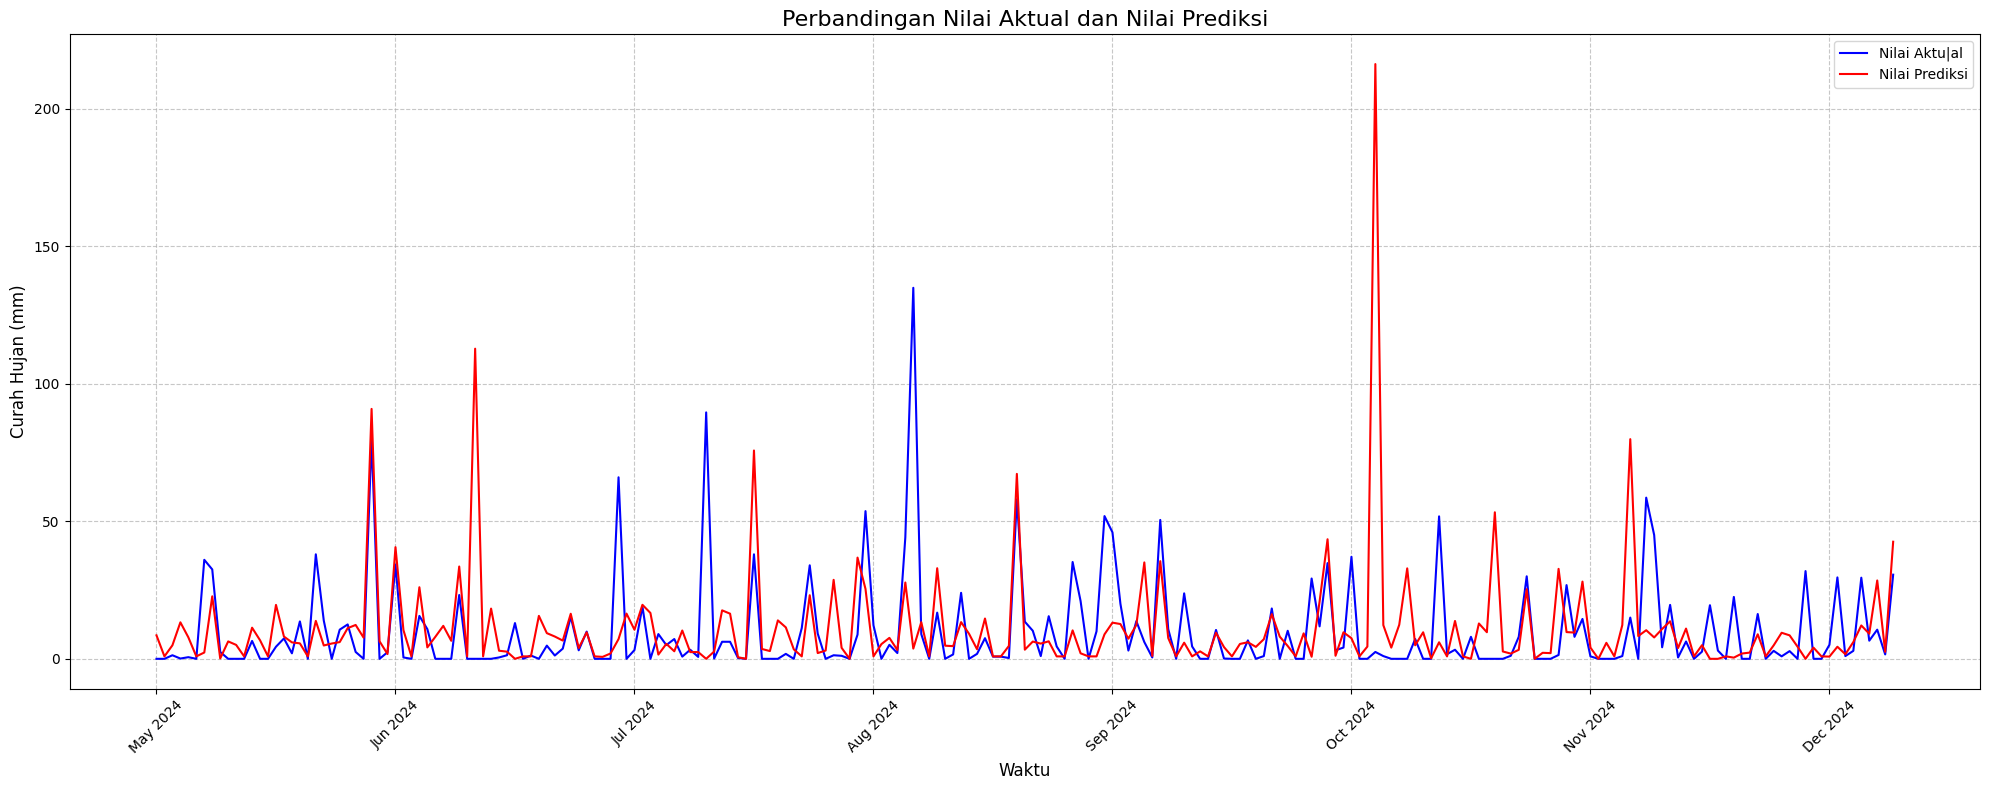

MAE for ELM model: 11.12456693650888
MSE for ELM model: 576.2940886275275


In [10]:
# Visualize the actual vs predicted extremes and the GEV fit
plt.figure(figsize=(20, 8))

# Plot data aktual (warna biru)
plt.plot(y_test, color='blue', label='Nilai Aktu|al')

# Plot prediksi (warna merah)
plt.plot(predictions, color='red', label='Nilai Prediksi')

# Menambahkan keterangan dan judul
plt.title('Perbandingan Nilai Aktual dan Nilai Prediksi', fontsize=16)
plt.xlabel('Waktu', fontsize=12)

# Menambahkan Tahun pada Sumbu X dengan hanya menampilkan setiap 12 bulan (1 tahun)
# Mengambil bulan dan tahun dari data uji
dates = data['Tanggal'].iloc[-len(y_test):]  # Ambil tanggal sesuai jumlah data uji
years_months = dates.dt.strftime('%b %Y')  # Menampilkan bulan dan tahun (misal: Jan 2022, Feb 2022)

# Menampilkan setiap label per 6 data (untuk mengurangi kepadatan)
plt.xticks(ticks=np.arange(0, len(dates), step=30), labels=years_months[::30], rotation=45, fontsize=10)

plt.ylabel('Curah Hujan (mm)', fontsize=12)

# Menambahkan legenda dan grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.tight_layout()
plt.show()

# Print the performance metrics (MAE, MSE)
print(f"MAE for ELM model: {mae_elm}")
print(f"MSE for ELM model: {mse_elm}")

In [11]:
# Step 3: Find extreme points (maximum rainfall) from actual and predicted values
actual_extremes = y_test[np.where(y_test == np.max(y_test))]
predicted_extremes = predictions[np.where(predictions == np.max(predictions))]

In [12]:
# Combine both actual and predicted extreme values
combined_extremes = np.concatenate((actual_extremes, predicted_extremes))

# Step 4: Apply EVT to model the extreme values
# Fit the GEV distribution to the extreme values
params = stats.genextreme.fit(combined_extremes)

In [13]:
# Output the fitted parameters (shape, location, scale)
shape, location, scale = params
print(f"Shape Parameter (Xi): {shape}")
print(f"Location Parameter (Mu): {location}")
print(f"Scale Parameter (Alpha): {scale}")

Shape Parameter (Xi): -1.7416497442648484
Location Parameter (Mu): 134.90000000000003
Scale Parameter (Alpha): 5.873987195329215e-14


In [14]:
# Step 5: Calculate the Return Level for a 2-year return period
return_period = 2  # 2 years return period
return_level = location + scale * ((-np.log(1 - 1 / return_period)) ** (-shape) - 1) / shape
print(f"Return Level (for {return_period} years): {return_level}")

Return Level (for 2 years): 134.90000000000006


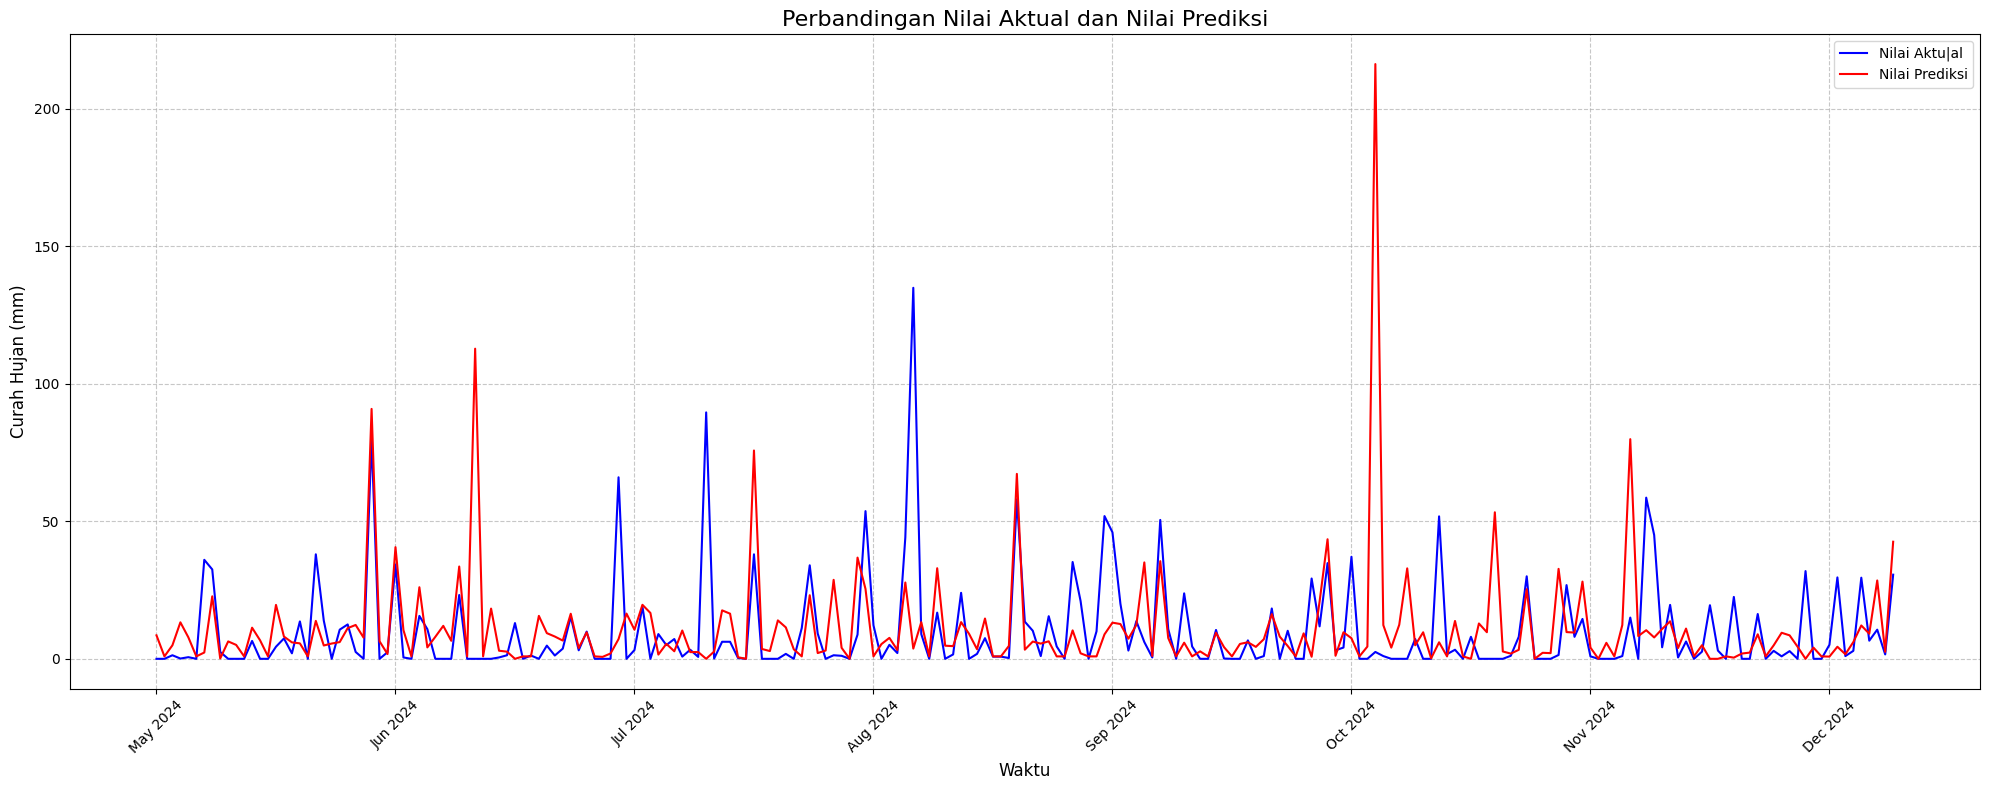

MAE for ELM model: 11.12456693650888
MSE for ELM model: 576.2940886275275


In [15]:
# Visualize the actual vs predicted extremes and the GEV fit
plt.figure(figsize=(20, 8))

# Plot data aktual (warna biru)
plt.plot(y_test, color='blue', label='Nilai Aktu|al')

# Plot prediksi (warna merah)
plt.plot(predictions, color='red', label='Nilai Prediksi')

# Menambahkan keterangan dan judul
plt.title('Perbandingan Nilai Aktual dan Nilai Prediksi', fontsize=16)
plt.xlabel('Waktu', fontsize=12)

# Menambahkan Tahun pada Sumbu X dengan hanya menampilkan setiap 12 bulan (1 tahun)
# Mengambil bulan dan tahun dari data uji
dates = data['Tanggal'].iloc[-len(y_test):]  # Ambil tanggal sesuai jumlah data uji
years_months = dates.dt.strftime('%b %Y')  # Menampilkan bulan dan tahun (misal: Jan 2022, Feb 2022)

# Menampilkan setiap label per 6 data (untuk mengurangi kepadatan)
plt.xticks(ticks=np.arange(0, len(dates), step=30), labels=years_months[::30], rotation=45, fontsize=10)

plt.ylabel('Curah Hujan (mm)', fontsize=12)

# Menambahkan legenda dan grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.tight_layout()
plt.show()

# Print the performance metrics (MAE, MSE)
print(f"MAE for ELM model: {mae_elm}")
print(f"MSE for ELM model: {mse_elm}")

Text(0.5, 1.0, 'Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

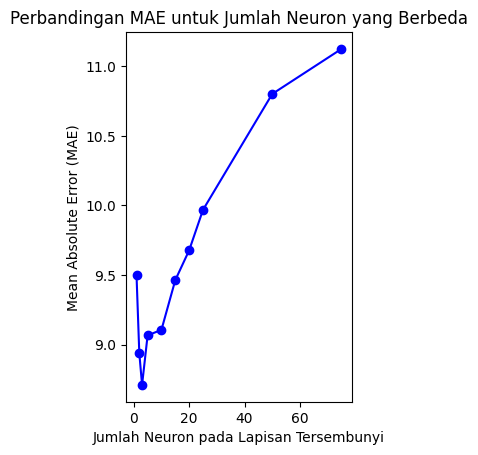

In [16]:
# Grafik MAE
plt.subplot(1, 2, 1)
plt.plot(hidden_sizes, mae_scores_for_hidden_sizes, marker='o', color='blue')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Perbandingan MAE untuk Jumlah Neuron yang Berbeda')

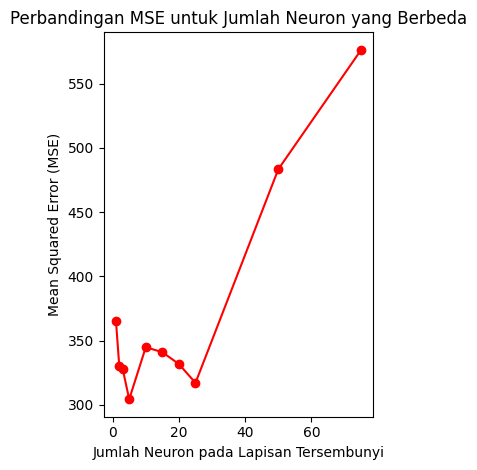

In [17]:
# Grafik MSE
plt.subplot(1, 2, 2)
plt.plot(hidden_sizes, mse_scores_for_hidden_sizes, marker='o', color='red')
plt.xlabel('Jumlah Neuron pada Lapisan Tersembunyi')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Perbandingan MSE untuk Jumlah Neuron yang Berbeda')

plt.tight_layout()
plt.show()